In [1]:
                                      # python 3.7.6
import matplotlib.pyplot as plt       # matplotlib 3.1.3
import numpy as np                    # numpy 1.18.1
import pandas as pd                   # pandas 1.0.1
from scipy.integrate import odeint    # scipy 1.4.1
from scipy.optimize import curve_fit  # scipy 1.4.1
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets          # ipygidgets 7.5.1
import datetime 
                
%matplotlib inline

# Model from Paper
*Quantifying Projected Impact of Social Distancing Policies on COVID-19 Outcomes in the US*
#### **Simple SIR** 
###### Interactive plot to compare parameters

In [2]:
def dNdt_simple(state, t, parameters, sim_num):
    """ Returns rate of change of simple SIR system. """
    S, I, R = state
    N = parameters['N_tot']
    beta = parameters['beta']
    gamma = parameters['gamma']

    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return dSdt, dIdt, dRdt


def f_simple(beta=0.429, gamma=0.111):
    """ Updates plot based on user-widget input. """
    param_simple = {
        'N_tot'          : 12600000,     # Illinois population
        'beta'           : beta,         # effective rate of spread (simple SIR) 
        'gamma'          : gamma}        # rate of recovery 
    days = 80
    time = np.linspace(0, days, days)
    state0 = [param_simple['N_tot']-10, 10, 0]
    state_simple = odeint(dNdt_simple, state0, time, args=(param_simple,1))      
    fig2, ax2 = plt.subplots(1, 1, figsize=(20,10))
    ax2.plot(time, state_simple[:,0], label='S', linewidth=1, color='blue') 
    ax2.plot(time, state_simple[:,1], label='I', linewidth=1, color='red') 
    ax2.plot(time, state_simple[:,2], label='R', linewidth=1, color='green') 
    ax2.set_xlabel('Days')
    ax2.set_ylabel('# of Individuals')

    
# Interactive widget choses which parameter to plot
figure2 = widgets.interact(f_simple, beta=(0.0,1.0,0.05), gamma=(0.01,0.3,0.01))


interactive(children=(FloatSlider(value=0.429, description='beta', max=1.0, step=0.05), FloatSlider(value=0.11…

###### Observe state data

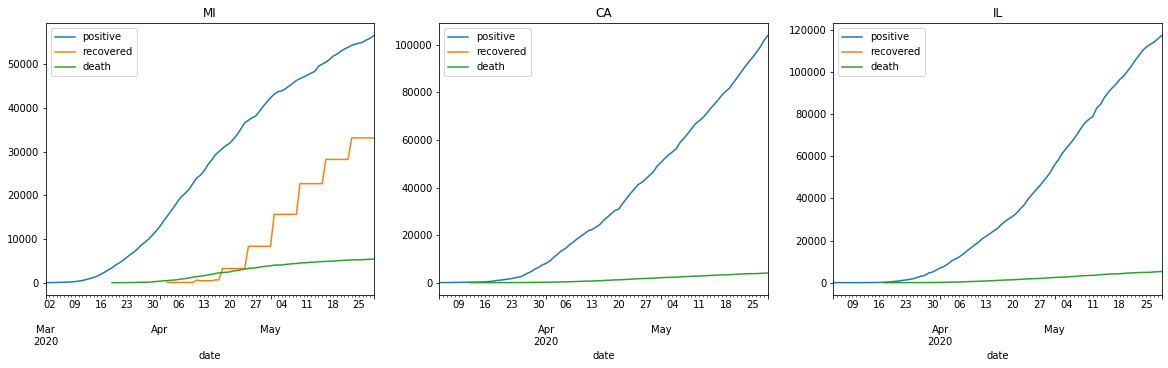

In [3]:
df_states = pd.read_csv('states_daily_4pm_et.csv')

# Convert date into datetime index
date_format = df_states['date'].to_numpy(dtype=str)
for i in np.arange(date_format.shape[0]):
    date_format[i] = datetime.datetime.strptime(date_format[i],'%Y%m%d').date().isoformat()
df_states['date'] = pd.to_datetime(date_format)
df_states.set_index('date', inplace=True)
df_states.sort_index(axis=0, ascending=True, inplace=True)

# Save data for states highly impacted by COVID-19
df_MI = df_states.loc[df_states['state'] == 'MI']
df_CA = df_states.loc[df_states['state'] == 'CA']
df_IL = df_states.loc[df_states['state'] == 'IL']

# Plot state data
fig3, ax3 = plt.subplots(1, 3, figsize=(20,5))
df_states.loc[df_states['state'] == 'MI'].plot(ax=ax3[0], y=['positive', 'recovered', 'death'], title='MI')
df_states.loc[df_states['state'] == 'CA'].plot(ax=ax3[1], y=['positive', 'recovered', 'death'], title='CA')
df_states.loc[df_states['state'] == 'IL'].plot(ax=ax3[2], y=['positive', 'recovered', 'death'], title='IL')


###### Michigan:

Background:
- March 10, 2020: first executive order Governor Whitmer was the Declaration of a State of Emergency which was issued on March 10 
    - 2 cases of coronavirus were confirmed in Michigan 
- March 13, 2020: temporary prohibition on large groups
    - Events hosting over 250 people be canceled/postponed.
- March 14, 2020: all health care facilities, residential care facilities, congregate care facilities and juvenile justice facilities prohibit any visitors 
- March 16, 2020: temporarily closing theaters, bars, casinos, limiting restaurants to carry-out and delivery orders
- May 1, 2020: highest death rate (deaths / confirmed cases) in country


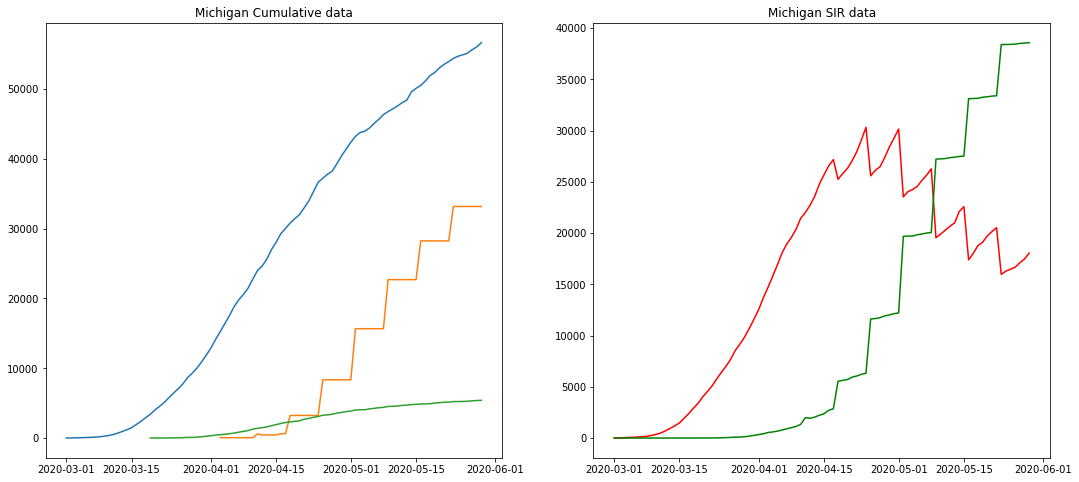

In [4]:
# Initial parameter 
params_MI = {
    'N_tot'          : 10000000,     
    'beta'           : 0.44,         
    'gamma'          : 0.0288}       

# Michigan Cumulative data
MI_pos = df_MI['positive'].fillna(value=0)                # 1st non-zero value 2020-03-01 (index=0) 9 case
MI_rec = df_MI['recovered'].fillna(value=0)               # 1st non-zero value 2020-04-03 (index=33)
MI_death = df_MI['death'].fillna(value=0)                 # 1st non-zero value 2020-03-19 (index = 18)

# Michigan SIR data (MI_S=susceptable, MI_I=infected, MI_R=removed)
MI_R = MI_rec + MI_death                                       
MI_I = MI_pos - MI_R                                           
MI_S = np.full(MI_I.shape, params_MI['N_tot']) - MI_R - MI_I   

# Plot cumulative data
fig4, ax4 = plt.subplots(1, 2, figsize=(18,8))
ax4[0].set_title('Michigan Cumulative data')
ax4[0].plot(df_MI.index, df_MI[['positive', 'recovered', 'death']], label='MI')

# Plot SIR data
ax4[1].set_title('Michigan SIR data')
ax4[1].plot(MI_I.index, MI_I, color='red', label='I')
ax4[1].plot(MI_R.index, MI_R, color='green', label='R')


Optimized parameters beta, gamma, I0:
 0.39226077886009136 0.07421648343913745 15.331073401167291 

Covariance of optimized parameters:
 [[ 3.79507396e+11  3.79507397e+11 -2.76031203e+02]
 [ 3.79507397e+11  3.79507398e+11 -2.76017171e+02]
 [-2.76027171e+02 -2.76013139e+02  2.37131368e+00]]


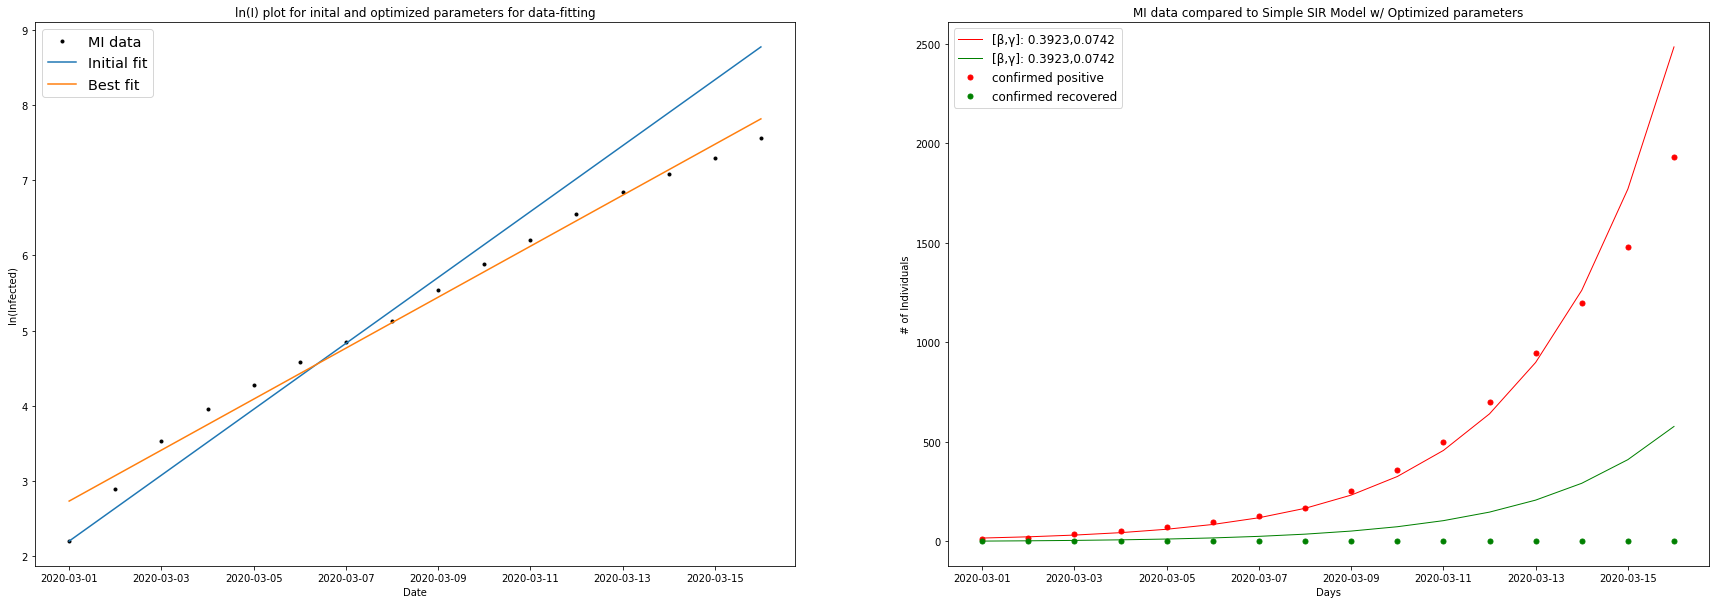

In [5]:
# Pre-quarentine time-period : 2020-03-01 (9 confirmed MI cases) to 2020-03-16 (start of quarentine)
days_MI = 16             
date_series = df_MI.index
date = date_series[0:days_MI]
t_MI = np.linspace(0, days_MI, days_MI)
MI_S_preQ = MI_S[0:days_MI]
MI_I_preQ = MI_I[0:days_MI] 
MI_R_preQ = MI_R[0:days_MI]

# Guess initial parameters
beta_g, gamma_g, I_0 = 0.44, 0.0288, 9   



# Linearize pre-quarentine data to find line best fit
def log_plot(t, beta, gamma, I0):
    """ Linear log plot to find """
    return (((beta-gamma)*t) + np.log(I0))

# Results of curve fitting 
ln_I = np.log(MI_I_preQ.to_numpy()) 
popt, pcov = curve_fit(log_plot, t_MI, ln_I, p0=[beta_g, gamma_g, I_0])
beta_opt, gamma_opt, I0_opt = popt
print('Optimized parameters beta, gamma, I0:\n', beta_opt, gamma_opt, I0_opt, '\n')
print('Covariance of optimized parameters:\n', pcov)

# Plot curve fitting results 
fig5, ax5 = plt.subplots(1,2,figsize=(30,10))

ax5[0].plot(date, ln_I, '.k', label='MI data')
ax5[0].plot(date, log_plot(t_MI, beta_g, gamma_g, I_0), label='Initial fit')
ax5[0].plot(date, log_plot(t_MI, beta_opt, gamma_opt, I0_opt), label='Best fit')
ax5[0].set_title('ln(I) plot for inital and optimized parameters for data-fitting')
ax5[0].set_xlabel('Date')
ax5[0].set_ylabel('ln(Infected)')
ax5[0].legend(fontsize='x-large')



# Simple SIR with optimized parameters
params_opt = {'N_tot'    : 10000000,        
              'beta'     : beta_opt,          # transmission rate  
              'gamma'    : gamma_opt}               
state0_opt = [(params_opt['N_tot']-I0_opt), I0_opt, 0]     
state_opt = odeint(dNdt_simple, state0_opt, t_MI, args=(params_opt,1)) 
param_label = "[β,γ]: " + str(np.around(beta_opt,decimals=4)) + ',' + str(np.around(gamma_opt,decimals=4))
ax5[1].plot(date, state_opt[:,1], c='r', label=param_label, markersize=10, linewidth=1) 
ax5[1].plot(date, state_opt[:,2], c='g', label=param_label, markersize=10, linewidth=1) 
     
# Plot MI data
ax5[1].plot(date, MI_I[0:days_MI], '.r', markersize=10, label='confirmed positive')
ax5[1].plot(date, MI_R[0:days_MI], '.g', markersize=10, label='confirmed recovered')
ax5[1].set_xlabel('Days')
ax5[1].set_ylabel('# of Individuals')
ax5[1].set_title('MI data compared to Simple SIR Model w/ Optimized parameters')
ax5[1].legend(fontsize='large')


*Results from parameter optimization:*
- Infection rate: $β = 0.392$
- Recovery rate: $γ = 0.0742 \quad (T_{recov} = \frac{1}{\gamma} = 13.5)$
- Basic reproductive number: $R_{0} = \frac{\beta}{\gamma}=5.36$

###### Simulate simple SIR for Michigan if NO quarentine was implemented 

Peak number infections:				 4954768.0
Total number of infections:			 62748.0
Fatality rate of ground truth data:		 9.5%
Fataility projection if no quarentine:		 944039.0 (if same fatality rate)
Fataility projection if no quarentine:		 94404.0 (0.1 * fatality rate)


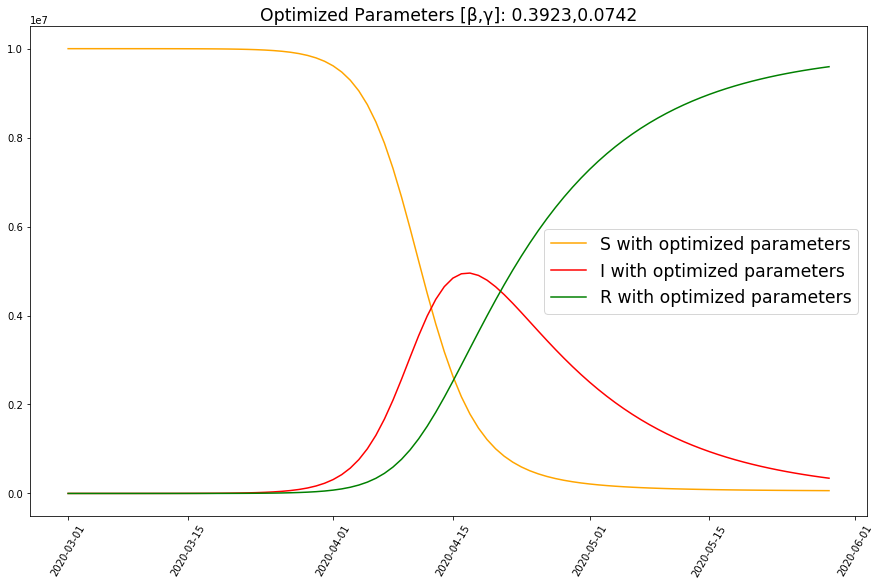

In [6]:
# Run simulation for same time-period as dataset
days_MI = MI_I.size   
date = MI_I.index
t_MI = np.linspace(0, days_MI, days_MI)
state0_sim = [(params_opt['N_tot']-I0_opt), I0_opt, 0]     
state_sim = odeint(dNdt_simple, state0_sim, t_MI, args=(params_opt,1)) 

plt.figure(figsize=(15,9))
plt.plot(date, state_sim[:,0], color='orange', label='S with optimized parameters')
plt.plot(date, state_sim[:,1], color='red', label='I with optimized parameters')
plt.plot(date, state_sim[:,2], color='green', label='R with optimized parameters') 
plt.legend(fontsize='xx-large')
plt.xticks(rotation=60)
plt.title('Optimized Parameters ' + param_label, fontsize='xx-large')

# Projected metrics if no quarentine implemented
S_final, I_final, R_final = np.around(state_sim[-1,:])
peak_I = np.around(np.max(state_sim[:,1]))
I_total = np.around(params_opt['N_tot']-S_final)
fatality_rate = np.around(MI_death[-1] / MI_pos[-1], decimals=3)
death_estHigh = np.around(fatality_rate * I_total)
death_estLow = np.around((fatality_rate/10) * I_total)

print('Peak number infections:\t\t\t\t', peak_I)
print('Total number of infections:\t\t\t', S_final)
print('Fatality rate of ground truth data:\t\t {:.1%}'.format(fatality_rate))
print('Fataility projection if no quarentine:\t\t', death_estHigh, '(if same fatality rate)')
print('Fataility projection if no quarentine:\t\t', death_estLow, '(0.1 * fatality rate)')


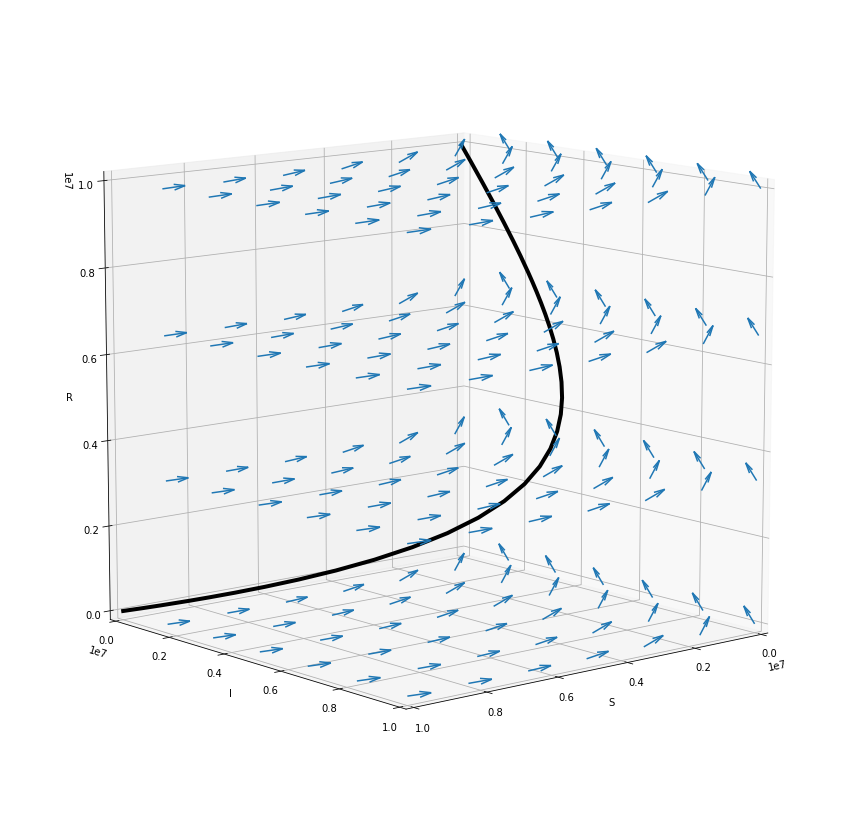

In [7]:
# # Phase portrait vectors  
Slim, Ilim, Rlim = [0, 10000000], [-0, 10000000], [0, 10000000]
sx, sy, sz = np.linspace(Slim[0], Slim[1], num=7), np.linspace(Ilim[0], Ilim[1], num=7), np.linspace(Rlim[0], Rlim[1], num=4) 
x, y, z = np.meshgrid(sx, sy, sz)
u, v, w = np.zeros(x.shape), np.zeros(y.shape), np.zeros(z.shape)
NI, NJ, NK = x.shape
for i in range(NI):
    for j in range(NJ):
        for k in range(NK):
            x1 = x[i,j,k]
            x2 = y[i,j,k]
            x3 = z[i,j,k]
            X = np.array([x1,x2,x3]).T
            Xdot = dNdt_simple(X,1,params_opt,1) 
            u[i,j,k] = Xdot[0]
            v[i,j,k] = Xdot[1]
            w[i,j,k] = Xdot[2]

# SIR projected trajectory over 1 year
t = np.linspace(0, 365, 365)
state0_traj = [(params_opt['N_tot']-I0_opt), I0_opt, 0]     
state_traj = odeint(dNdt_simple, state0_traj, t, args=(params_opt,1)) 

# Plot trajectory and phase portrait
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')
ax.quiver(x, y, z, u, v, w, cmap='hsv', length=500000, arrow_length_ratio=0.5, normalize=True)
ax.plot(state_traj[:,0], state_traj[:,1], state_traj[:,2], linewidth = 4, color='k')  

ax.set_xlim(Slim)
ax.set_ylim(Ilim)
ax.set_zlim(Rlim)
ax.set_xlabel('S')
ax.set_ylabel('I')
ax.set_zlabel('R')
ax.view_init(elev= 11, azim=50)


# 5) Domain-specific SIR Model (Paper 3)

- $n$ = number of domains 
- $D_{i}$ = domain $i$
- $N_{i}$ = people in domain $i$
- $η_{i}$ = avg time in domain $i$
- $ζ_{i}$ = frac of $S(t)$ in domain $i$
- $κ_{i}$ = frac of $I(t)$ in domain $i$
- $β_{i}$ = transmission rate from one $I_{i}$ (to $S_{i}$) per day
- $τ_{i}$ = transmission probability per encounter
- $c_{i}$ = number of encounters $I_{i}$ makes with member of domain $i$


#### With perfect mixing 
- *Worst-case scenerio*: no precautionary measures that test and isolate infected individuals 
    - Pessimistic worst-case: $\frac{τ^{'}_{eq}}{τ_{eq}} = 0.7829$
    - Optimistic worst-case: $\frac{τ^{'}_{eq}}{τ_{eq}} = 0.5668$

In [8]:
# Mixing-domain SIR for homogeneous population (infected are not identified & no contact tracing)
def dNdt_mix(state, t, parameters, sim_num):
    """Returns rate of change of perfect mixing domains SIR system."""
    S, I, R = state
    N = parameters['N_tot']
    gamma = parameters['gamma']
    tau_eq = parameters['tau_eq']

    dSdt = -(tau_eq*S*I)
    dIdt = (tau_eq*S*I) - (gamma*I)
    dRdt = gamma*I
    return dSdt, dIdt, dRdt


# Updtate interactive plot
def f_mix(tau, eta, alpha):
    tau_eq = tau*eta*np.square(alpha)
    params_mix = {'N_tot'  : 12600000,            # total Illinois population
                 'tau_eq'  : tau_eq,              # effective rate of spread (simple SIR) 
                 'gamma'   : gamma_opt}           # rate of recovery 
    days = 100
    time = np.linspace(0, days, days)
    state0_mix = [params_mix['N_tot']-10, 10, 0]
    state_mix = odeint(dNdt_mix, state0_mix, time, args=(params_mix,1))   
    
    fig6, ax6 = plt.subplots(1, 1, figsize=(20,10))
    ax6.plot(time, state_mix[:,0], label='S', linewidth=1, color='blue') 
    ax6.plot(time, state_mix[:,1], label='I', linewidth=1, color='red') 
    ax6.plot(time, state_mix[:,2], label='R', linewidth=1, color='green') 
    ax6.set_xlabel('Days')
    ax6.set_ylabel('# of Individuals')
    ax6.set_title('Mixing domain SIR Model')
    ax6.legend()


# Widgets for interactive plot
tau_slider1 = widgets.FloatSlider(
    value=0.1000,
    min=0.000,
    max=0.500,
    step=0.001,
    description='tau_i',
    readout_format='.4f',
    continuous_update=True)

eta_slider1 = widgets.FloatSlider(
    value=0.166,        # 4hr/24hr
    min=0.0,
    max=1.0,
    step=0.007,         # 10min / 24 hour
    description='eta_i',
    readout_format='.4f',
    continuous_update=True)

alpha_slider1 = widgets.FloatSlider(
    value=0.00159,       # 20000/12600000
    min=0.00000,
    max=0.1,
    step=0.00005,
    description='alpha_i',
    readout_format='.5f',
    continuous_update=True)

# Interactive widget choses which parameter to plot
widgets.interact(f_mix, tau=tau_slider1, eta=eta_slider1, alpha=alpha_slider1)



interactive(children=(FloatSlider(value=0.1, description='tau_i', max=0.5, readout_format='.4f', step=0.001), …

<function __main__.f_mix(tau, eta, alpha)>

###### With time delay for quarentine

In [9]:
# Interactive plot to visualize different parameter sets
def dNdt_SD(state, t, parameters, sim_num):
    """Returns rate of change of perfect mixing domains SIR system."""
    # Unpack state variables
    S, I, R = state
    gamma = parameters['gamma']
    tau_eq = parameters['tau_eq']
    tau_ratio = parameters['tau_ratio']
    c1 = parameters['c1']
    t0 = parameters['t0']
    
    if t < t0:
        ft = 1
    else:
        ft = tau_ratio + ((1 - tau_ratio)*np.exp(-c1*(t-t0))) 
            
    dSdt = -(tau_eq*ft*S*I) 
    dIdt = (tau_eq*ft*S*I) - (gamma*I)
    dRdt = gamma*I
    return dSdt, dIdt, dRdt


def f_SD(tau, eta, alpha, gamma, tauRatio, t0, c1):
    tau_eq = tau*eta*np.square(alpha)
    params_SD = {'N_tot'          : 12600000,        # total Illinois population
                 'tau_eq'         : tau_eq,          # effective rate of spread (simple SIR) 
                 'gamma'          : gamma,           # rate of recovery 
                 'tau_ratio'      : tauRatio,
                 't0'             : t0,
                 'c1'             : c1}       
    days = 60
    time = np.linspace(0, days, 1000)
    state0 = [params_SD['N_tot']-10, 10, 0]
    state_SD = odeint(dNdt_SD, state0, time, args=(params_SD,1))   

    fig7, ax7 = plt.subplots(1, 1, figsize=(20,10))
    ax7.plot(time, state_SD[:,0], label='S', linewidth=1, color='blue') 
    ax7.plot(time, state_SD[:,1], label='I', linewidth=1, color='red') 
    ax7.plot(time, state_SD[:,2], label='R', linewidth=1, color='green') 
    ax7.set_xlabel('Days')
    ax7.set_ylabel('# of Individuals')
    ax7.set_title('Mixing domain SIR Model')
    ax7.legend()

    
tau_slider2 = widgets.FloatSlider(
    value=0.100,
    min=0.000,
    max=0.500,
    step=0.001,
    description='tau_i',
    readout_format='.4f',
    continuous_update=True)

eta_slider2 = widgets.FloatSlider(
    value=0.077,
    min=0.000,
    max=0.300,
    step=0.001,
    description='eta_i',
    readout_format='.4f',
    continuous_update=True)

alpha_slider2 = widgets.FloatSlider(
    value=0.00230,
    min=0.0000,
    max=0.0100,
    step=0.0001,
    description='alpha_i',
    readout_format='.5f',
    continuous_update=True)

gamma_slider2 = widgets.FloatSlider(
    value=gamma_opt,
    min=0.010,
    max=0.300,
    step=0.030,
    description='gamma_i',
    readout_format='.4f',
    continuous_update=True)    

tauRatio_slider2 = widgets.Dropdown(
    options = [('Optimistic', 0.5668), ('Pessimistic', 0.7829)],
    value = 0.5668,
    description = 'Tau ratio',
    continuous_update = True)     

t0_slider2 = widgets.IntSlider(
    value = 11,
    min = 0,
    max = 60,
    step = 1.,
    description = 'Days after 1st case quarentine starts',
    readout_format = '.2f',
    continuous_update = True)

c1_slider2 = widgets.FloatSlider(
    value = 3.,
    min = 0.,
    max = 10.,
    step = 1.,
    description = 'c1',
    readout_format = '.2f',
    continuous_update = True)

# Interactive widget choses which parameter to plot
widgets.interact(f_SD, tau=tau_slider2, eta=eta_slider2, alpha=alpha_slider2, gamma=gamma_slider2, tauRatio=tauRatio_slider2,t0=t0_slider2, c1=c1_slider2)
 

interactive(children=(FloatSlider(value=0.1, description='tau_i', max=0.5, readout_format='.4f', step=0.001), …

<function __main__.f_SD(tau, eta, alpha, gamma, tauRatio, t0, c1)>

## IHME Data

In [10]:
# Global data
df_ihme = pd.read_csv('IHME_data.csv', header=0, index_col='location_name')
# Illinois Data
il_ihme = df_ihme.loc['Illinois']
il_data = il_ihme.set_index('date')
il_data.head()


,V1,allbed_mean,allbed_lower,allbed_upper,ICUbed_mean,ICUbed_lower,ICUbed_upper,InvVen_mean,InvVen_lower,InvVen_upper,...,totdea_lower_smoothed,totdea_upper_smoothed,mobility_data_type,mobility_composite,total_tests_data_type,total_tests,confirmed_infections,est_infections_mean,est_infections_lower,est_infections_upper
date,,,,,,,,,,,,,,,,,,,,,
2019-12-13,19455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-14,19456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-15,19457,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-16,19458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-17,19459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


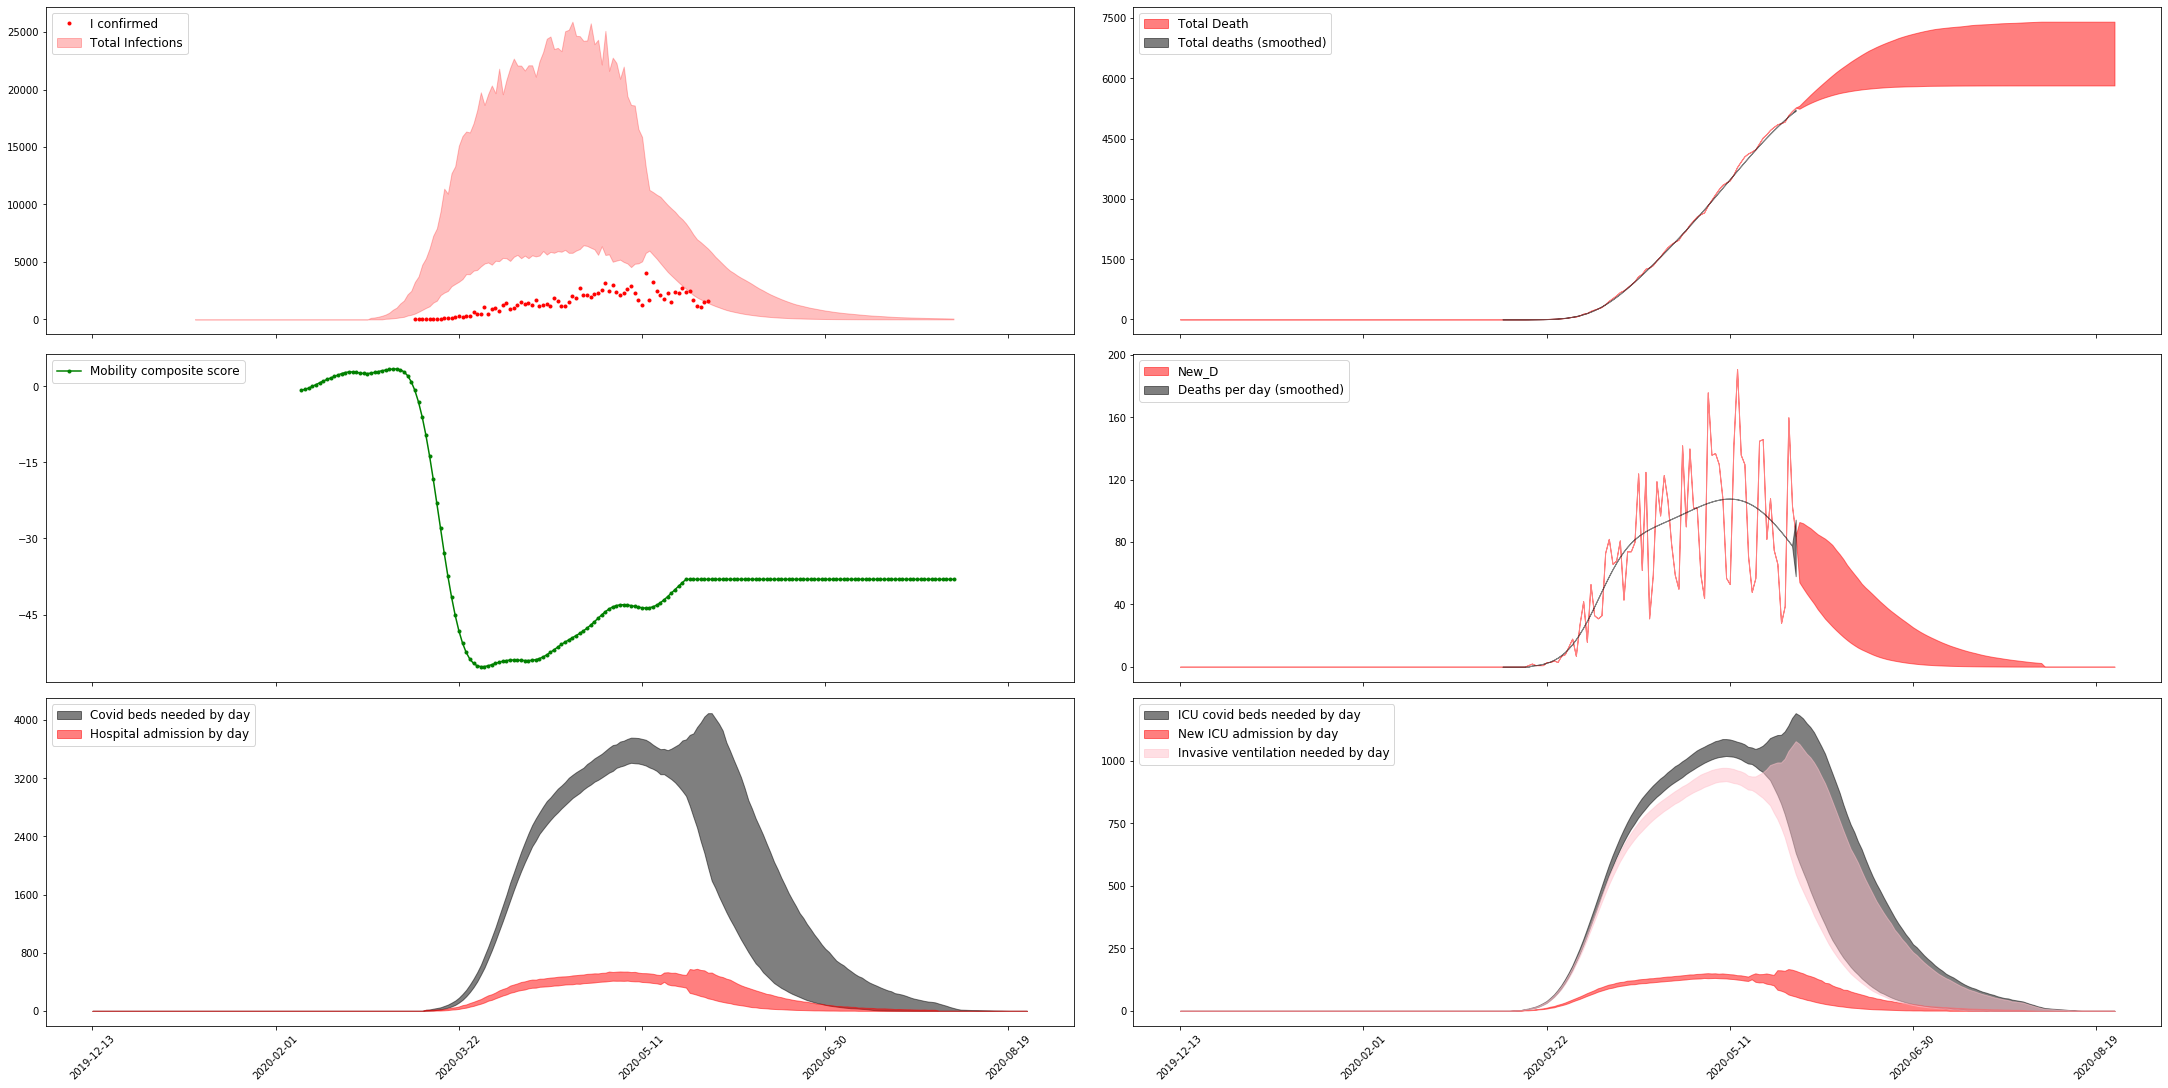

In [11]:
# Plot IHME Data
confI = il_data[['confirmed_infections']]
estI = il_data[['est_infections_lower', 'est_infections_mean', 'est_infections_upper']]
totD = il_data[['totdea_lower', 'totdea_mean', 'totdea_upper']]
newD = il_data[['deaths_lower', 'deaths_mean', 'deaths_upper']]
smooth_newD = il_data[['deaths_lower_smoothed', 'deaths_mean_smoothed', 'deaths_upper_smoothed']]
smooth_totD = il_data[['totdea_lower_smoothed', 'totdea_mean_smoothed', 'totdea_upper_smoothed']]
tot_test = il_data[['total_tests', 'total_tests_data_type']]
all_beds = il_data[['allbed_lower', 'allbed_mean', 'allbed_upper']] # Covid beds needed by day
ICU_beds = il_data[['ICUbed_lower', 'ICUbed_mean', 'ICUbed_upper']] # ICU covid beds needed by day
InvVen = il_data[['InvVen_lower', 'InvVen_mean', 'InvVen_upper']] # Invasive ventilation needed by day
admis = il_data[['admis_lower', 'admis_mean', 'admis_upper']]  # Hospital admision by day
new_ICU = il_data[['newICU_lower', 'newICU_mean', 'newICU_upper']] # Num of new people going to ICU by day
mobility_composite = il_data[['mobility_composite', 'mobility_data_type']]


fig8, ax8 = plt.subplots(3, 2, sharex=True, constrained_layout=True, figsize=(30,15))

# Infections (w/ predicted range)
ax8[0,0].plot(confI.index, confI, '.r', label='I confirmed')
ax8[0,0].fill_between(estI.index, estI['est_infections_lower'], estI['est_infections_upper'], label='Total Infections', alpha=0.25, color='red')

# Cumulative total death (w/ predicted range)
ax8[0,1].fill_between(totD.index, totD['totdea_lower'], totD['totdea_upper'], label='Total Death', alpha=0.5, color='red')
ax8[0,1].fill_between(smooth_totD.index, smooth_totD['totdea_lower_smoothed'], smooth_totD['totdea_upper_smoothed'], label='Total deaths (smoothed)', alpha=0.5, color='k')

# Mobility/SD
ax8[1,0].plot(mobility_composite.index, mobility_composite['mobility_composite'], '.-g', label='Mobility composite score')

# Deaths per day (w/ predicted range)
ax8[1,1].fill_between(newD.index, newD['deaths_lower'], newD['deaths_upper'], label='New_D', alpha=0.5, color='red')
ax8[1,1].fill_between(smooth_newD.index, smooth_newD['deaths_lower_smoothed'], smooth_newD['deaths_upper_smoothed'], label='Deaths per day (smoothed)', alpha=0.5, color='k')

# Hospital beds (w/ predicted range)
ax8[2,0].fill_between(all_beds.index, all_beds['allbed_lower'], all_beds['allbed_upper'], label='Covid beds needed by day', color='black', alpha=0.5)
ax8[2,0].fill_between(admis.index, admis['admis_lower'], admis['admis_upper'], label='Hospital admission by day', color='red', alpha=0.5)

# ICU bends 
ax8[2,1].fill_between(ICU_beds.index, ICU_beds['ICUbed_lower'], ICU_beds['ICUbed_upper'], label='ICU covid beds needed by day', color='black', alpha=0.5)
ax8[2,1].fill_between(new_ICU.index, new_ICU['newICU_lower'], new_ICU['newICU_upper'], label='New ICU admission by day', color='red', alpha=0.5)
ax8[2,1].fill_between(InvVen.index, InvVen['InvVen_lower'], InvVen['InvVen_upper'], label='Invasive ventilation needed by day', color='pink', alpha=0.5)

for axi in ax8.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(6))
    axi.yaxis.set_major_locator(plt.MaxNLocator(6))
    axi.legend(fontsize='large', loc='upper left')
    labels = axi.get_xticklabels()
    plt.setp(labels, rotation=45)


In [12]:
# Interactive plot to visualize different parameter sets
confI_data = confI[76:98]  # index = 88: First confirmed case 03-10 (I=20)                  
estI_data = estI[76:98]    # index = 76: First estimated case 02-27 (I_l=0.000000, I_m=17.579794, I_u=132.790076)
                           # use index 76 - 170 (170 is current), Quarentine started 3-21 

def dNdt_SD(state, t, parameters, sim_num):
    """Returns rate of change of perfect mixing domains SIR system."""
    S, I, R = state
    gamma = parameters['gamma']
    tau_eq = parameters['tau_eq']
    tau_ratio = parameters['tau_ratio']
    c1 = parameters['c1']
    t0 = parameters['t0']
    
    if t < t0:
        ft = 1
    else:
        ft = tau_ratio + ((1 - tau_ratio)*np.exp(-c1*(t-t0))) 
            
    dSdt = -(tau_eq*ft*S*I) 
    dIdt = (tau_eq*ft*S*I) - (gamma*I)
    dRdt = gamma*I
    return dSdt, dIdt, dRdt


def f_SD(tau, eta, alpha, gamma, tauRatio, t0, c1):
    tau_eq = tau*eta*np.square(alpha)
    params_SD = {'N_tot'          : 12600000,        # total Illinois population
                 'tau_eq'         : tau_eq,          # effective rate of spread (simple SIR) 
                 'gamma'          : gamma,           # rate of recovery 
                 'tau_ratio'      : tauRatio,
                 't0'             : t0,
                 'c1'             : c1}       
    # 1st data  2019-12-13 (V1=19455):  I=0
    # 1st I data  2020-2-27 (V1=19531):  I_est_m = 17.6 
    days = estI_data.shape[0]
    time = np.linspace(0, days, days)
    date_series = estI_data.index
    state0 = [params_SD['N_tot']-10, 10, 0]
    state = odeint(dNdt_SD, state0, time, args=(params_SD,1))   

    fig9, ax9 = plt.subplots(1, 1, figsize=(20,10))
    ax9.plot(date_series, state[:,1], label='SIR infection projection (ours)', linewidth=1, color='red') 
    ax9.plot(date_series, estI_data['est_infections_mean'], 'xr', label='Mean value for infection extimate (paper)')
    ax9.fill_between(date_series, estI_data['est_infections_lower'], estI_data['est_infections_upper'], label='Uncertainty range for infection estimate (paper)', alpha=0.25, color='red')
    ax9.set_xlabel('Days')
    ax9.set_ylabel('# of Individuals')
    ax9.set_title('Mixing domain SIR Model')
    ax9.legend()
    plt.xticks(rotation=60) 
    

tau_slider3 = widgets.FloatSlider(
    value=0.100,
    min=0.000,
    max=0.500,
    step=0.001,
    description='tau_i',
    readout_format='.4f',
    continuous_update=True)

eta_slider3 = widgets.FloatSlider(
    value=0.077,
    min=0.000,
    max=0.300,
    step=0.001,
    description='eta_i',
    readout_format='.4f',
    continuous_update=True)

alpha_slider3 = widgets.FloatSlider(
    value=0.00220,
    min=0.0000,
    max=0.0100,
    step=0.0001,
    description='alpha_i',
    readout_format='.5f',
    continuous_update=True)

gamma_slider3 = widgets.FloatSlider(
    value=gamma_opt,
    min=0.010,
    max=0.300,
    step=0.030,
    description='gamma_i',
    readout_format='.4f',
    continuous_update=True)    

tauRatio_slider3 = widgets.Dropdown(
    options = [('Optimistic', 0.5668), ('Pessimistic', 0.7829)],
    value = 0.5668,
    description = 'Tau ratio',
    continuous_update = True) 

t0_slider3 = widgets.IntSlider(
    value = 11,
    min = 0,
    max = 60,
    step = 1.,
    description = 't0',
    readout_format = '.2f',
    continuous_update = True)

c1_slider3 = widgets.FloatSlider(
    value = 3.,
    min = 0.,
    max = 10.,
    step = 1.,
    description = 'c1',
    readout_format = '.2f',
    continuous_update = True)


# Interactive widget choses which parameter to plot
widgets.interact(f_SD, tau=tau_slider3, eta=eta_slider3, alpha=alpha_slider3, gamma=gamma_slider3, tauRatio=tauRatio_slider3,t0=t0_slider3, c1=c1_slider3)
 

interactive(children=(FloatSlider(value=0.1, description='tau_i', max=0.5, readout_format='.4f', step=0.001), …

<function __main__.f_SD(tau, eta, alpha, gamma, tauRatio, t0, c1)>